# OSKM States

Colour cells by combination of OKSM expressed in the cells.

Inputs:
1. Seurat RNA object

In [137]:
library(Seurat)
library(ggplot2)
library(reshape2)
library(patchwork)

## Load Inputs
### Seurat Object

In [4]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")
rna$tech = "rna"

## Plotting

In [5]:
oskm_expr = as.matrix(rna@assays$RNA[c("POU5F1", "SOX2", "KLF4", "MYC")])
head(oskm_expr)

,AAACCCAAGAGTGACC-1,AAACCCAAGTGCCAGA-1,AAACCCACACCATTCC-1,AAACCCACACGCGTCA-1,AAACCCAGTCCATAGT-1,AAACCCAGTTATTCTC-1,AAACCCAGTTGTAGCT-1,AAACCCATCAGACATC-1,AAACCCATCCGTAGGC-1,AAACCCATCGTTAGAC-1,⋯,TTTGTTGCAACCACAT-8,TTTGTTGCAGCGTGCT-8,TTTGTTGCAGGACTTT-8,TTTGTTGGTACCTGTA-8,TTTGTTGGTCAAGCCC-8,TTTGTTGGTCCTGGTG-8,TTTGTTGGTCGTTATG-8,TTTGTTGGTCTGTCAA-8,TTTGTTGTCCCTGGTT-8,TTTGTTGTCGTCTACC-8
POU5F1,0.0000000,0.000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0,0,⋯,2.4499997,2.7512612,1.8937520,1.789098,2.903551,2.8492077,3.0446201,0,2.7682245,2.537593
SOX2,0.0000000,0.000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0,0,⋯,1.3249977,0.8368753,0.5912925,0.000000,0.000000,0.9980779,0.9316204,0,0.0000000,1.465184
KLF4,0.5902506,0.000000,0.5671873,0.8148389,0,0.0000000,0.0000000,0.0000000,0,0,⋯,0.3786849,0.5796897,0.5912925,1.096483,0.000000,0.0000000,1.2709861,0,0.0000000,0.000000
MYC,0.0000000,1.028412,0.5671873,0.0000000,0,0.5729634,0.5869346,0.6510742,0,0,⋯,1.9437243,1.2108847,0.9603624,2.992697,1.385807,1.2724516,1.4054200,0,0.4401724,0.000000


In [6]:
# kNN smoothing
# oskm_expr = as.matrix(oskm_expr %*% rna@graphs$RNA_nn)

In [95]:
oskm_bin = matrix(0, nrow(oskm_expr), ncol(oskm_expr))
rownames(oskm_bin) = rownames(oskm_expr)

for (f in rownames(oskm_expr)) {
#     oskm_bin[f, ] = oskm_expr[f, ] > quantile(rna@assays$RNA@data[f, rna$sample=="D0"], .99)
    oskm_bin[f, ] = oskm_expr[f, ] > quantile(oskm_expr[f, ], 0.5) #quantile(rna@assays$RNA@data[f,], .5)
#     oskm_bin[f, ] = oskm_expr[f, ] > quantile(oskm_expr[f, rna$sample=="D0"], .95)
}

In [96]:
states = matrix(0, 1, ncol(oskm_expr))

for (i in seq(nrow(oskm_bin))) {
    states[1,] = states[1,] + (2**(i-1))*oskm_bin[i, ]
}

In [97]:
factors = c("O", "S", "K", "M")
state_names = rep("", 15)

for (i in seq(4)) {
    for (j in seq(15)) {
        if ( (j%/%2**(i-1)) %% 2 == 1) {
            state_names[j] = paste(state_names[j], factors[i], sep='')
        }
    }
}

state_names = c("NONE", state_names, "Other")
state_names

[1] "NONE"  "O"     "S"     "OS"    "K"     "OK"    "SK"    "OSK"   "M"    
[10] "OM"    "SM"    "OSM"   "KM"    "OKM"   "SKM"   "OSKM"  "Other"

In [98]:
sort(table(states[1,]))


    6     5     9     2    10    13     1    14    12     3    11     8     4 
  755   818   946  1044  1150  1261  1345  1421  2237  2282  2694  2703  2854 
    7    15     0 
 3066 17272 17521 

In [99]:
# keep states with > N cells
STATE_MIN_CELLS = 2000

sum(states[1,] %in% names(table(states[1,]))[table(states[1,])<STATE_MIN_CELLS])

# mark rest as "other"
states[1,][states[1,] %in% names(table(states[1,]))[table(states[1,])<STATE_MIN_CELLS]] = 16

[1] 8740

In [100]:
state_to_color = data.frame(i=seq(1,17),
                           s=state_names,
                           c=c("black", # NONE
                               "darkred", #O
                               "darkblue", #S
                               "chartreuse3", #OS
                               "darkorange4", #K
                               "darkorange3", # OK
                               "coral", #SK
                               "cyan4", #OSK
                               "darkgreen", #M
                               "brown1", #OM
                               "blue2", #SM
                               "darkorchid", #OSM
                               "darkorange2", #KM
                               "darkorange", #OKM
                               "darksalmon", #SKM
                               "deepskyblue", #OSKM
                               "grey") # other
                           )

state_to_color

i,s,c
<int>,<fct>,<fct>
1,NONE,black
2,O,darkred
3,S,darkblue
4,OS,chartreuse3
5,K,darkorange4
6,OK,darkorange3
7,SK,coral
8,OSK,cyan4
9,M,darkgreen


In [101]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    guides(colour = guide_legend(title="Day",
         override.aes = list(shape=16, alpha=1, size=4)))
}

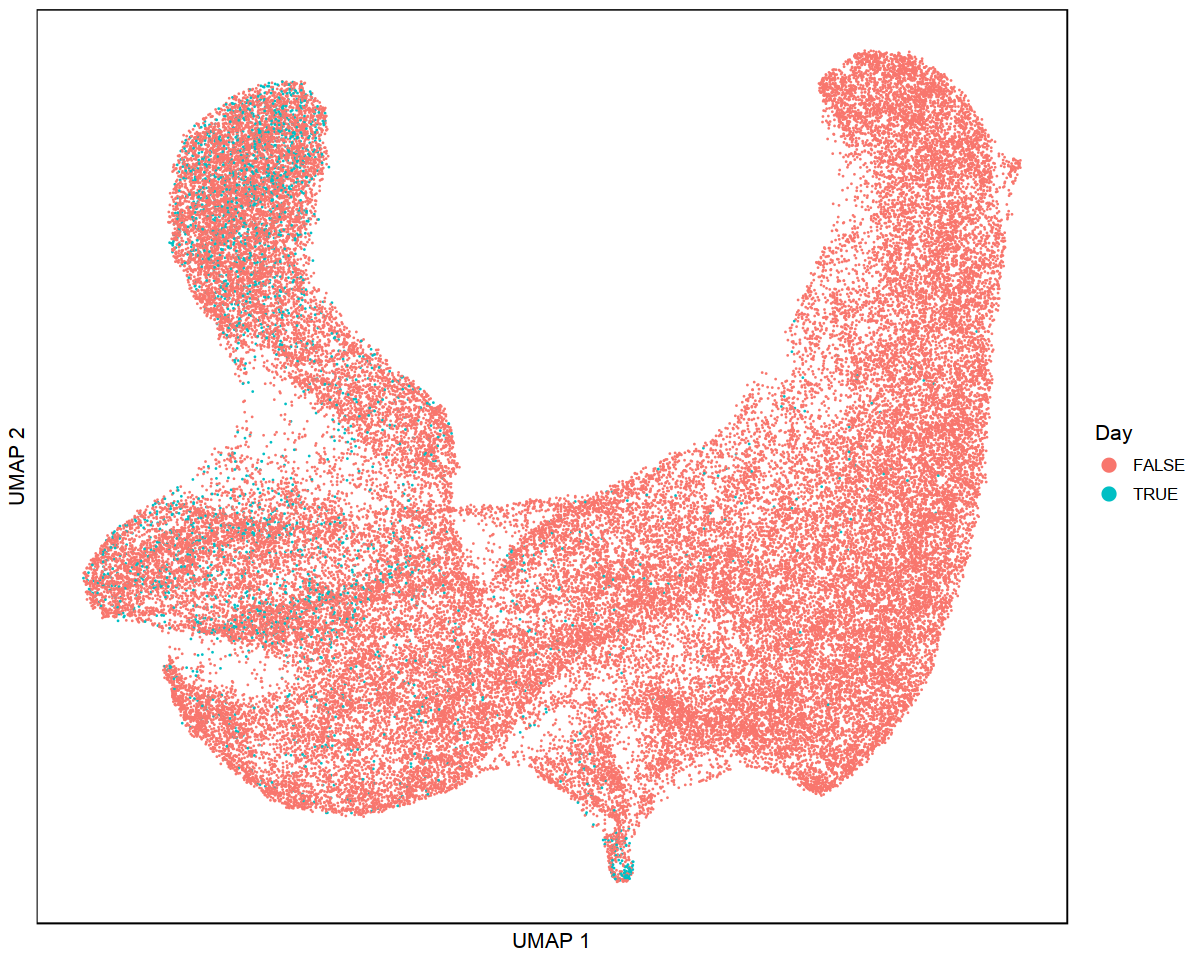

In [102]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_dimred(data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
            data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
            factor(state_names[as.vector(states+1)])=="K")

In [103]:
cols = as.character(state_to_color$c)
names(cols) = state_to_color$s
cols

NONE             O             S            OS             K 
      "black"     "darkred"    "darkblue" "chartreuse3" "darkorange4" 
           OK            SK           OSK             M            OM 
"darkorange3"       "coral"       "cyan4"   "darkgreen"      "brown1" 
           SM           OSM            KM           OKM           SKM 
      "blue2"  "darkorchid" "darkorange2"  "darkorange"  "darksalmon" 
         OSKM         Other 
"deepskyblue"        "grey"

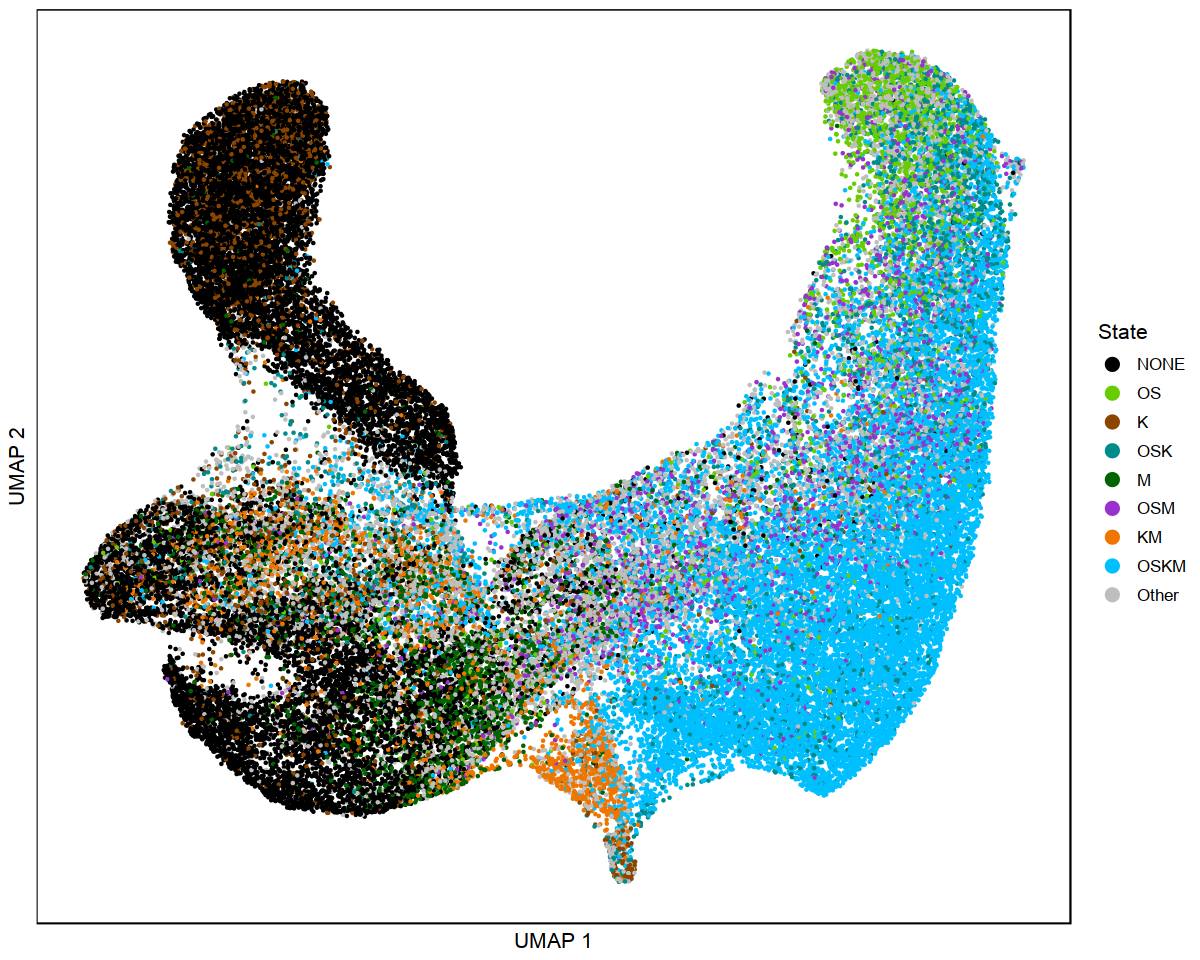

In [104]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_dimred(data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
            data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
            factor(state_names[as.vector(states+1)], levels=state_names), 
           sz=1) + scale_color_manual(values=cols) +
guides(color=guide_legend(title="State",
                         override.aes = list(shape=16, alpha=1, size=4)))

## Clustering Based

In [105]:
library(ClusterR)

In [106]:
dim(oskm_expr)

[1]     4 59369

In [239]:
NUM_PEAK_SETS = 8
km_mb = MiniBatchKmeans(t(oskm_expr), 
                        batch_size = 1000,
                        clusters = NUM_PEAK_SETS,
                        num_init = 50, 
                        verbose = FALSE)

In [262]:
pr_mb = predict_MBatchKMeans(t(oskm_expr), km_mb$centroids)

In [263]:
# sort centroids by average expr and renumber
pr_mb = order(order(rowSums(km_mb$centroids)))[pr_mb]

In [264]:
sort(table(pr_mb))

pr_mb
    5     8     7     3     2     4     6     1 
 1681  2056  5584  6767  6889  7936  9886 18570 

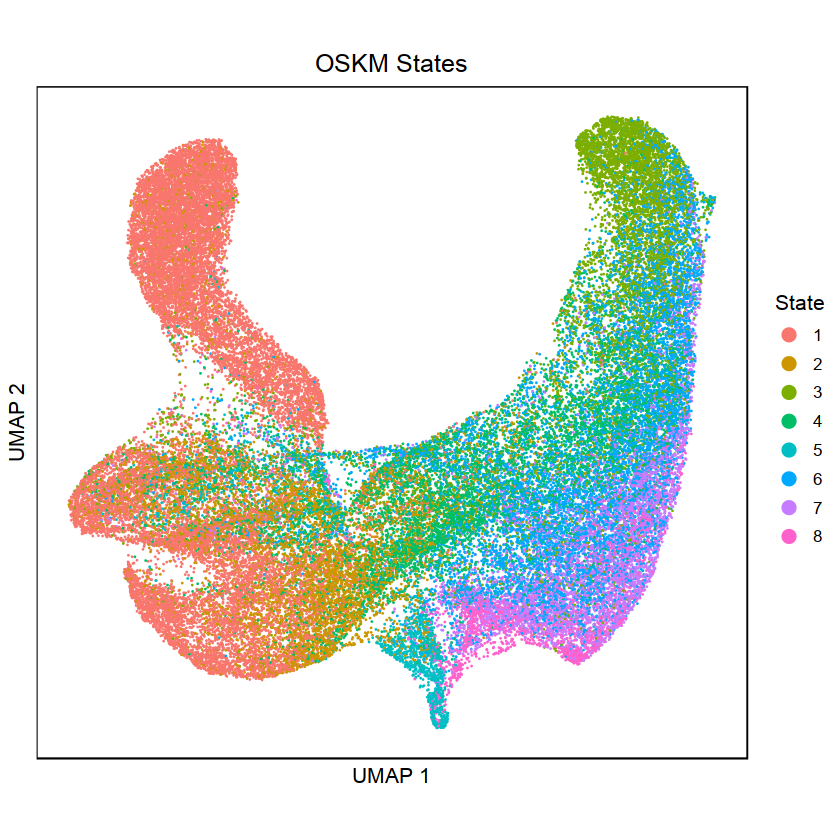

In [374]:
options(repr.plot.width = 7, repr.plot.height = 7)

state_plot <- plot_dimred(data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
            data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
            factor(pr_mb),
           sz=.5) +# + scale_color_manual(values=cols) +
guides(color=guide_legend(title="State",
                         override.aes = list(shape=16, alpha=1, size=4))) +
ggtitle("OSKM States") +
coord_fixed() 

state_plot

In [270]:
km_mb$centroids[order(rowSums(km_mb$centroids)), ]

0.07179388,0.02332036,0.1399018,0.1942497
0.31390503,0.09283104,0.2933887,1.8209136
2.38330018,0.60587274,0.5239459,1.0412117
1.62986898,0.56719894,0.6277865,2.0256020
0.57841735,0.26988811,2.8075183,2.4522411
2.51138718,1.25412897,1.3129600,2.1401828
3.18970392,2.05807146,2.1330859,2.5848413
4.04011291,3.02890963,3.0789297,2.8270271


In [403]:
LABELS = c("None", 
           "Mid M",
           "Mid O, Low SKM",
           "Mid OM, Low SK",
           "High KM, Low OS", 
           "Mid OSKM", 
           "High OSKM", 
           "Very high OSKM")

COLORS = c("#6f1000", 
           "#fdc086",
           "#29C460",
           "#5762D5",
           "#00A7E1",
           "black",
           "cadetblue2",
           "#f0027f"
          )

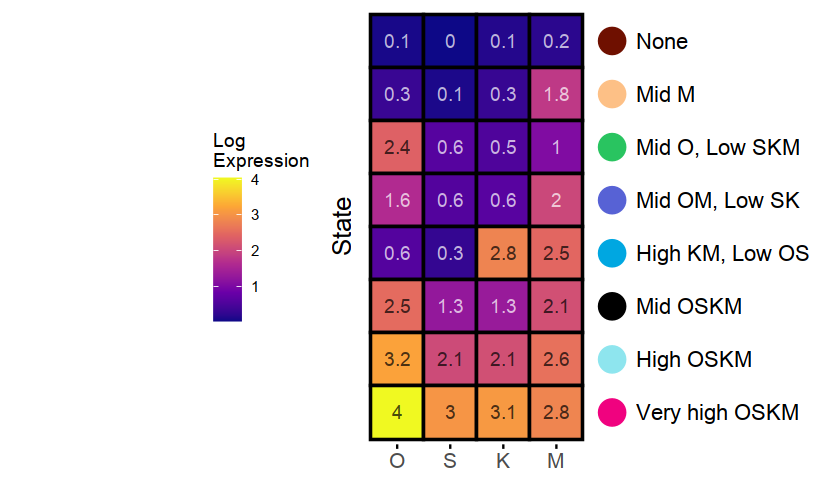

In [404]:
options(repr.plot.width = 7, repr.plot.height = 4)

centroids = km_mb$centroids
centroids = centroids[order(rowSums(centroids)), ]
colnames(centroids) = c("O", "S", "K", "M")
centroids = melt(centroids)
centroids$Var1 = factor(centroids$Var1, levels=rev(seq(NUM_PEAK_SETS)))
centroids$rounded = round(centroids$value, digits=1)

legend_plot <- ggplot(centroids) +
geom_tile(aes(x=Var2, 
              y=Var1, 
              fill=value),
         col="black", size=.75) +
scale_fill_viridis_c(option = "C", name="Log\nExpression") +

geom_text(aes(x=Var2, y=Var1, label=rounded, colour=(rounded>2)), alpha=.7) +
scale_colour_manual(values = c("white", "black")) +

xlab(NULL) + 
ylab("State") +
theme_minimal() +
coord_fixed(clip="off") +
guides(colour=FALSE) +
theme(axis.ticks.x = element_line(colour = "black"),
     axis.text=element_text(size=12),
     axis.text.y = element_blank(),
     axis.title=element_text(size=15),
     legend.position="left",
     panel.grid.major = element_blank())

for (i in seq(length(LABELS))) {
    legend_plot <- legend_plot + annotate(geom = "point", 
                                          x = 5.05, y = (NUM_PEAK_SETS-i+1),
                                         colour = COLORS[i], 
                                         size = 7)
    legend_plot <- legend_plot + annotate("text", 
                                          x=5.5, 
                                          y=(NUM_PEAK_SETS-i+1), 
                                          label=LABELS[i], 
                                          hjust=0,
                                         size=4.5)
}

legend_plot

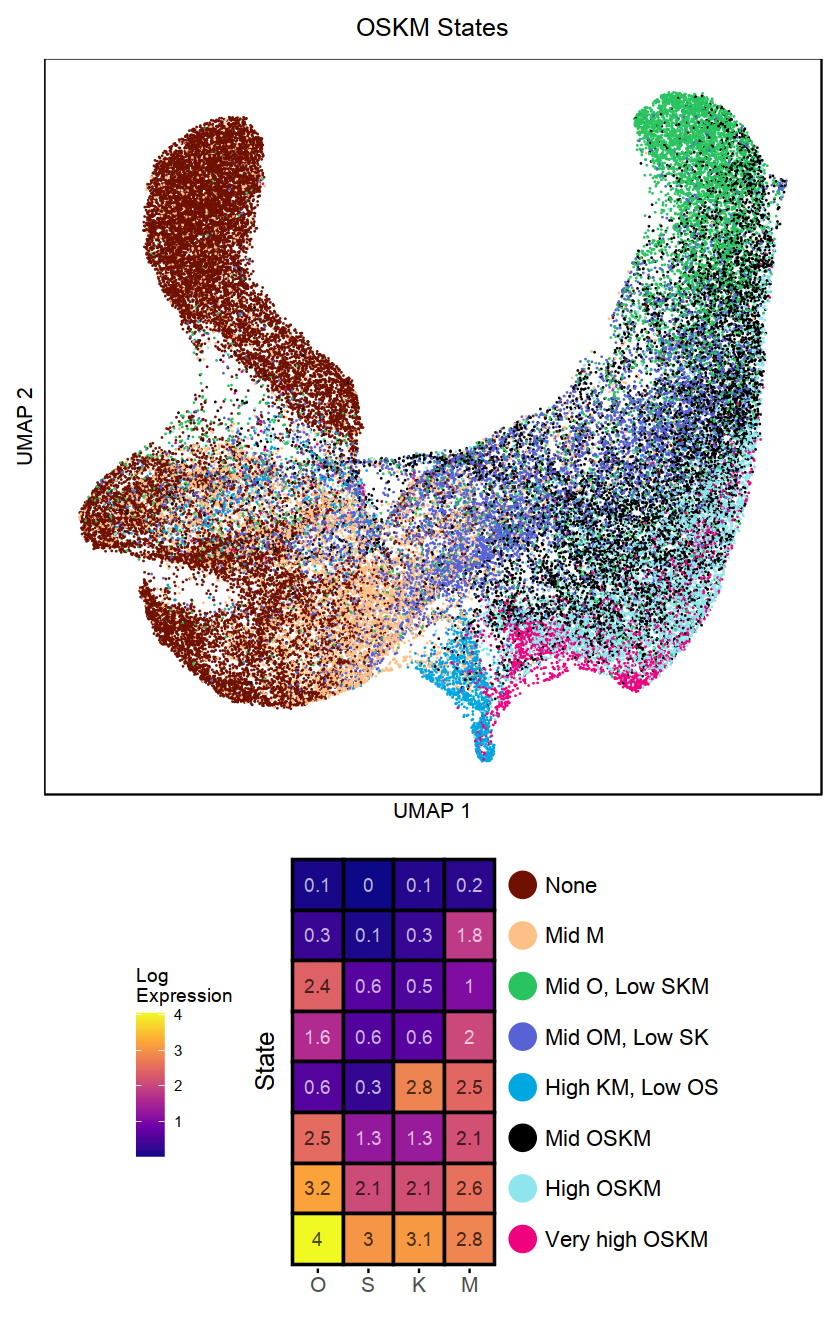

In [405]:
options(repr.plot.width = 7, repr.plot.height = 11)

# TODO: stoichiometry papers v high OSKM = non reprog?
# switching off of exogenous K at late stage

state_plot_coloured = state_plot + 
    scale_color_manual(values=COLORS) +
    theme(legend.position="none") 

combined_plot <- wrap_plots(state_plot_coloured,
          wrap_plots(plot_spacer(), legend_plot, plot_spacer(), widths=c(0.5,2,2)),
          heights=c(7,4))

combined_plot

In [407]:
saveRDS(combined_plot, file=sprintf("./subfigs/%s_OSKM_states.rds",
                                   format(Sys.Date(), "%Y%m%d")))

---

In [12]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0 Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] httr_1.4.1          tidyr_1.1.2         jsonlite_1.6.1     
 [4] viridisLite_0.3.0   splines_3.6.3       lsei_1.2-0         
 [7] leiden_0.3.3        ggrepel_0.8.2       globals_0.12.5     
[10] pillar_1.4.6        lat